# 請結合前面的知識與程式碼，比較不同的 optimizer 與 learning rate 組合對訓練的結果與影響
### 常見的 optimizer 包含
* SGD
* RMSprop
* AdaGrad
* Adam

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
import os
import keras
import itertools

In [3]:
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = [1e-1, 1e-2, 1e-3, 1e-4]
EPOCHS = 50
BATCH_SIZE = 256
optimizer=[keras.optimizers.SGD,keras.optimizers.RMSprop,keras.optimizers.Adagrad,
          keras.optimizers.Adam]

In [12]:
results = {}
for lr, opt in itertools.product(LEARNING_RATE, optimizer):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with LR = %.6f,optimizer = %s" % (lr,str(opt)))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    optimizer = opt(lr=lr)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"]
                  , optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "exp-lr-%s-momemtum-%s" % (str(lr), str(opt))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with LR = 0.100000,optimizer = <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Epoch 1

196/196 [==============================] - 1s 4ms/step - loss: 0.7525 - accuracy: 0.7321 - val_loss: 1.9994 - val_accuracy: 0.4560
Experiment with LR = 0.100000,optimizer = <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890

196/196 [==============================] - 1s 5ms/step - loss: 2.3082 - accuracy: 0.1004 - val_loss: 2.3256 - val_accuracy: 0.1000
Epoch 50/50
196/196 [==============================] - 1s 5ms/step - loss: 2.3087 - accuracy: 0.0996 - val_loss: 2.3092 - val_accuracy: 0.1000
Experiment with LR = 0.100000,optimizer = <class 'tensorflow.python.keras.optimizer_v2.adagrad.Adagrad'>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
____________

196/196 [==============================] - 1s 4ms/step - loss: 0.9103 - accuracy: 0.6738 - val_loss: 1.5639 - val_accuracy: 0.4945
Epoch 49/50
196/196 [==============================] - 1s 4ms/step - loss: 0.8780 - accuracy: 0.6830 - val_loss: 1.6084 - val_accuracy: 0.4983
Epoch 50/50
196/196 [==============================] - 1s 4ms/step - loss: 0.8638 - accuracy: 0.6893 - val_loss: 1.7179 - val_accuracy: 0.4692
Experiment with LR = 0.100000,optimizer = <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_______

196/196 [==============================] - 1s 4ms/step - loss: 2.3070 - accuracy: 0.0987 - val_loss: 2.3060 - val_accuracy: 0.1000
Epoch 48/50
196/196 [==============================] - 1s 4ms/step - loss: 2.3061 - accuracy: 0.1019 - val_loss: 2.3053 - val_accuracy: 0.1000
Epoch 49/50
196/196 [==============================] - 1s 4ms/step - loss: 2.3070 - accuracy: 0.0986 - val_loss: 2.3053 - val_accuracy: 0.1000
Epoch 50/50
196/196 [==============================] - 1s 4ms/step - loss: 2.3071 - accuracy: 0.0961 - val_loss: 2.3100 - val_accuracy: 0.1000
Experiment with LR = 0.010000,optimizer = <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)           

196/196 [==============================] - 1s 4ms/step - loss: 1.2514 - accuracy: 0.5641 - val_loss: 1.5220 - val_accuracy: 0.4603
Epoch 47/50
196/196 [==============================] - 1s 4ms/step - loss: 1.2467 - accuracy: 0.5593 - val_loss: 1.5051 - val_accuracy: 0.4648
Epoch 48/50
196/196 [==============================] - 1s 4ms/step - loss: 1.2472 - accuracy: 0.5620 - val_loss: 1.3954 - val_accuracy: 0.5077
Epoch 49/50
196/196 [==============================] - 1s 4ms/step - loss: 1.2351 - accuracy: 0.5676 - val_loss: 1.6071 - val_accuracy: 0.4371
Epoch 50/50
196/196 [==============================] - 1s 4ms/step - loss: 1.2325 - accuracy: 0.5677 - val_loss: 1.4366 - val_accuracy: 0.4827
Experiment with LR = 0.010000,optimizer = <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]  

196/196 [==============================] - 1s 5ms/step - loss: 2.3032 - accuracy: 0.0963 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 46/50
196/196 [==============================] - 1s 5ms/step - loss: 2.3031 - accuracy: 0.1005 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 47/50
196/196 [==============================] - 1s 5ms/step - loss: 2.3032 - accuracy: 0.0981 - val_loss: 2.3033 - val_accuracy: 0.1000
Epoch 48/50
196/196 [==============================] - 1s 5ms/step - loss: 2.3032 - accuracy: 0.0974 - val_loss: 2.3032 - val_accuracy: 0.1000
Epoch 49/50
196/196 [==============================] - 1s 5ms/step - loss: 2.3030 - accuracy: 0.1033 - val_loss: 2.3029 - val_accuracy: 0.1000
Epoch 50/50
196/196 [==============================] - 1s 5ms/step - loss: 2.3031 - accuracy: 0.0994 - val_loss: 2.3030 - val_accuracy: 0.1000
Experiment with LR = 0.010000,optimizer = <class 'tensorflow.python.keras.optimizer_v2.adagrad.Adagrad'>
Model: "model"
__________________________________

196/196 [==============================] - 1s 4ms/step - loss: 1.1008 - accuracy: 0.6153 - val_loss: 1.7323 - val_accuracy: 0.4337
Epoch 45/50
196/196 [==============================] - 1s 4ms/step - loss: 1.0819 - accuracy: 0.6209 - val_loss: 1.5481 - val_accuracy: 0.4706
Epoch 46/50
196/196 [==============================] - 1s 4ms/step - loss: 1.0588 - accuracy: 0.6340 - val_loss: 1.3310 - val_accuracy: 0.5296
Epoch 47/50
196/196 [==============================] - 1s 4ms/step - loss: 1.0388 - accuracy: 0.6377 - val_loss: 1.4110 - val_accuracy: 0.5074
Epoch 48/50
196/196 [==============================] - 1s 4ms/step - loss: 1.0493 - accuracy: 0.6343 - val_loss: 1.3326 - val_accuracy: 0.5317
Epoch 49/50
196/196 [==============================] - 1s 4ms/step - loss: 1.0175 - accuracy: 0.6459 - val_loss: 1.4018 - val_accuracy: 0.5129
Epoch 50/50
196/196 [==============================] - 1s 4ms/step - loss: 1.0202 - accuracy: 0.6452 - val_loss: 1.5279 - val_accuracy: 0.4785
Experiment 

196/196 [==============================] - 1s 4ms/step - loss: 1.5636 - accuracy: 0.4388 - val_loss: 1.6862 - val_accuracy: 0.3990
Epoch 44/50
196/196 [==============================] - 1s 4ms/step - loss: 1.5663 - accuracy: 0.4341 - val_loss: 1.5968 - val_accuracy: 0.4319
Epoch 45/50
196/196 [==============================] - 1s 4ms/step - loss: 1.5643 - accuracy: 0.4381 - val_loss: 1.6252 - val_accuracy: 0.4198
Epoch 46/50
196/196 [==============================] - 1s 4ms/step - loss: 1.5537 - accuracy: 0.4457 - val_loss: 1.6825 - val_accuracy: 0.4107
Epoch 47/50
196/196 [==============================] - 1s 4ms/step - loss: 1.5672 - accuracy: 0.4389 - val_loss: 1.6488 - val_accuracy: 0.4157
Epoch 48/50
196/196 [==============================] - 1s 4ms/step - loss: 1.5683 - accuracy: 0.4381 - val_loss: 1.6642 - val_accuracy: 0.4083
Epoch 49/50
196/196 [==============================] - 1s 4ms/step - loss: 1.5624 - accuracy: 0.4374 - val_loss: 1.6352 - val_accuracy: 0.4269
Epoch 50/50

196/196 [==============================] - 1s 4ms/step - loss: 1.7089 - accuracy: 0.4051 - val_loss: 1.7076 - val_accuracy: 0.4058
Epoch 43/50
196/196 [==============================] - 1s 4ms/step - loss: 1.7044 - accuracy: 0.4073 - val_loss: 1.7018 - val_accuracy: 0.4061
Epoch 44/50
196/196 [==============================] - 1s 4ms/step - loss: 1.7026 - accuracy: 0.4080 - val_loss: 1.6989 - val_accuracy: 0.4103
Epoch 45/50
196/196 [==============================] - 1s 4ms/step - loss: 1.7008 - accuracy: 0.4075 - val_loss: 1.6944 - val_accuracy: 0.4103
Epoch 46/50
196/196 [==============================] - 1s 4ms/step - loss: 1.6918 - accuracy: 0.4132 - val_loss: 1.6931 - val_accuracy: 0.4107
Epoch 47/50
196/196 [==============================] - 1s 4ms/step - loss: 1.6874 - accuracy: 0.4139 - val_loss: 1.6896 - val_accuracy: 0.4112
Epoch 48/50
196/196 [==============================] - 1s 4ms/step - loss: 1.6871 - accuracy: 0.4143 - val_loss: 1.6856 - val_accuracy: 0.4128
Epoch 49/50

196/196 [==============================] - 1s 5ms/step - loss: 0.8773 - accuracy: 0.6893 - val_loss: 1.8135 - val_accuracy: 0.4788
Epoch 42/50
196/196 [==============================] - 1s 5ms/step - loss: 0.8565 - accuracy: 0.6908 - val_loss: 1.7480 - val_accuracy: 0.4794
Epoch 43/50
196/196 [==============================] - 1s 5ms/step - loss: 0.8475 - accuracy: 0.6930 - val_loss: 1.9433 - val_accuracy: 0.4636
Epoch 44/50
196/196 [==============================] - 1s 5ms/step - loss: 0.8460 - accuracy: 0.6975 - val_loss: 1.8298 - val_accuracy: 0.4945
Epoch 45/50
196/196 [==============================] - 1s 5ms/step - loss: 0.8296 - accuracy: 0.7049 - val_loss: 1.8644 - val_accuracy: 0.4815
Epoch 46/50
196/196 [==============================] - 1s 5ms/step - loss: 0.8182 - accuracy: 0.7068 - val_loss: 1.9824 - val_accuracy: 0.4835
Epoch 47/50
196/196 [==============================] - 1s 5ms/step - loss: 0.8036 - accuracy: 0.7128 - val_loss: 1.9326 - val_accuracy: 0.4778
Epoch 48/50

196/196 [==============================] - 1s 4ms/step - loss: 1.5625 - accuracy: 0.4587 - val_loss: 1.5846 - val_accuracy: 0.4481
Epoch 41/50
196/196 [==============================] - 1s 4ms/step - loss: 1.5547 - accuracy: 0.4592 - val_loss: 1.5667 - val_accuracy: 0.4573
Epoch 42/50
196/196 [==============================] - 1s 4ms/step - loss: 1.5438 - accuracy: 0.4659 - val_loss: 1.5628 - val_accuracy: 0.4569
Epoch 43/50
196/196 [==============================] - 1s 4ms/step - loss: 1.5455 - accuracy: 0.4612 - val_loss: 1.5645 - val_accuracy: 0.4532
Epoch 44/50
196/196 [==============================] - 1s 4ms/step - loss: 1.5442 - accuracy: 0.4654 - val_loss: 1.5603 - val_accuracy: 0.4544
Epoch 45/50
196/196 [==============================] - 1s 4ms/step - loss: 1.5363 - accuracy: 0.4664 - val_loss: 1.5495 - val_accuracy: 0.4614
Epoch 46/50
196/196 [==============================] - 1s 4ms/step - loss: 1.5339 - accuracy: 0.4618 - val_loss: 1.5545 - val_accuracy: 0.4599
Epoch 47/50

196/196 [==============================] - 1s 4ms/step - loss: 0.7589 - accuracy: 0.7313 - val_loss: 1.5333 - val_accuracy: 0.5369
Epoch 40/50
196/196 [==============================] - 1s 4ms/step - loss: 0.7423 - accuracy: 0.7361 - val_loss: 1.5552 - val_accuracy: 0.5263
Epoch 41/50
196/196 [==============================] - 1s 4ms/step - loss: 0.7437 - accuracy: 0.7318 - val_loss: 1.6392 - val_accuracy: 0.5167
Epoch 42/50
196/196 [==============================] - 1s 4ms/step - loss: 0.7244 - accuracy: 0.7400 - val_loss: 1.6305 - val_accuracy: 0.5206
Epoch 43/50
196/196 [==============================] - 1s 4ms/step - loss: 0.6983 - accuracy: 0.7532 - val_loss: 1.6360 - val_accuracy: 0.5242
Epoch 44/50
196/196 [==============================] - 1s 4ms/step - loss: 0.7010 - accuracy: 0.7514 - val_loss: 1.6636 - val_accuracy: 0.5263
Epoch 45/50
196/196 [==============================] - 1s 4ms/step - loss: 0.6647 - accuracy: 0.7668 - val_loss: 1.6555 - val_accuracy: 0.5262
Epoch 46/50

196/196 [==============================] - 1s 4ms/step - loss: 2.0684 - accuracy: 0.2846 - val_loss: 2.0644 - val_accuracy: 0.2854
Epoch 39/50
196/196 [==============================] - 1s 4ms/step - loss: 2.0651 - accuracy: 0.2849 - val_loss: 2.0606 - val_accuracy: 0.2876
Epoch 40/50
196/196 [==============================] - 1s 4ms/step - loss: 2.0600 - accuracy: 0.2875 - val_loss: 2.0568 - val_accuracy: 0.2888
Epoch 41/50
196/196 [==============================] - 1s 4ms/step - loss: 2.0542 - accuracy: 0.2911 - val_loss: 2.0531 - val_accuracy: 0.2906
Epoch 42/50
196/196 [==============================] - 1s 4ms/step - loss: 2.0497 - accuracy: 0.2939 - val_loss: 2.0495 - val_accuracy: 0.2919
Epoch 43/50
196/196 [==============================] - 1s 4ms/step - loss: 2.0457 - accuracy: 0.2942 - val_loss: 2.0460 - val_accuracy: 0.2930
Epoch 44/50
196/196 [==============================] - 1s 4ms/step - loss: 2.0456 - accuracy: 0.2931 - val_loss: 2.0425 - val_accuracy: 0.2947
Epoch 45/50

196/196 [==============================] - 1s 5ms/step - loss: 1.0707 - accuracy: 0.6274 - val_loss: 1.4353 - val_accuracy: 0.4971
Epoch 38/50
196/196 [==============================] - 1s 5ms/step - loss: 1.0596 - accuracy: 0.6321 - val_loss: 1.3357 - val_accuracy: 0.5314
Epoch 39/50
196/196 [==============================] - 1s 5ms/step - loss: 1.0377 - accuracy: 0.6389 - val_loss: 1.4154 - val_accuracy: 0.5159
Epoch 40/50
196/196 [==============================] - 1s 5ms/step - loss: 1.0394 - accuracy: 0.6358 - val_loss: 1.4889 - val_accuracy: 0.4882
Epoch 41/50
196/196 [==============================] - 1s 5ms/step - loss: 1.0252 - accuracy: 0.6426 - val_loss: 1.4928 - val_accuracy: 0.4920
Epoch 42/50
196/196 [==============================] - 1s 5ms/step - loss: 1.0182 - accuracy: 0.6458 - val_loss: 1.3549 - val_accuracy: 0.5319
Epoch 43/50
196/196 [==============================] - 1s 5ms/step - loss: 1.0077 - accuracy: 0.6508 - val_loss: 1.6016 - val_accuracy: 0.4611
Epoch 44/50

196/196 [==============================] - 1s 4ms/step - loss: 1.8992 - accuracy: 0.3409 - val_loss: 1.8983 - val_accuracy: 0.3366
Epoch 37/50
196/196 [==============================] - 1s 4ms/step - loss: 1.8965 - accuracy: 0.3388 - val_loss: 1.8949 - val_accuracy: 0.3371
Epoch 38/50
196/196 [==============================] - 1s 4ms/step - loss: 1.8872 - accuracy: 0.3468 - val_loss: 1.8912 - val_accuracy: 0.3383
Epoch 39/50
196/196 [==============================] - 1s 4ms/step - loss: 1.8890 - accuracy: 0.3433 - val_loss: 1.8879 - val_accuracy: 0.3391
Epoch 40/50
196/196 [==============================] - 1s 4ms/step - loss: 1.8824 - accuracy: 0.3444 - val_loss: 1.8846 - val_accuracy: 0.3405
Epoch 41/50
196/196 [==============================] - 1s 4ms/step - loss: 1.8782 - accuracy: 0.3453 - val_loss: 1.8815 - val_accuracy: 0.3411
Epoch 42/50
196/196 [==============================] - 1s 4ms/step - loss: 1.8743 - accuracy: 0.3513 - val_loss: 1.8787 - val_accuracy: 0.3423
Epoch 43/50

196/196 [==============================] - 1s 4ms/step - loss: 0.9774 - accuracy: 0.6607 - val_loss: 1.3105 - val_accuracy: 0.5434
Epoch 36/50
196/196 [==============================] - 1s 4ms/step - loss: 0.9682 - accuracy: 0.6644 - val_loss: 1.3350 - val_accuracy: 0.5345
Epoch 37/50
196/196 [==============================] - 1s 4ms/step - loss: 0.9615 - accuracy: 0.6688 - val_loss: 1.3239 - val_accuracy: 0.5362
Epoch 38/50
196/196 [==============================] - 1s 4ms/step - loss: 0.9528 - accuracy: 0.6701 - val_loss: 1.3457 - val_accuracy: 0.5333
Epoch 39/50
196/196 [==============================] - 1s 4ms/step - loss: 0.9448 - accuracy: 0.6700 - val_loss: 1.3241 - val_accuracy: 0.5414
Epoch 40/50
196/196 [==============================] - 1s 4ms/step - loss: 0.9155 - accuracy: 0.6858 - val_loss: 1.3521 - val_accuracy: 0.5394
Epoch 41/50
196/196 [==============================] - 1s 4ms/step - loss: 0.8980 - accuracy: 0.6887 - val_loss: 1.3636 - val_accuracy: 0.5357
Epoch 42/50

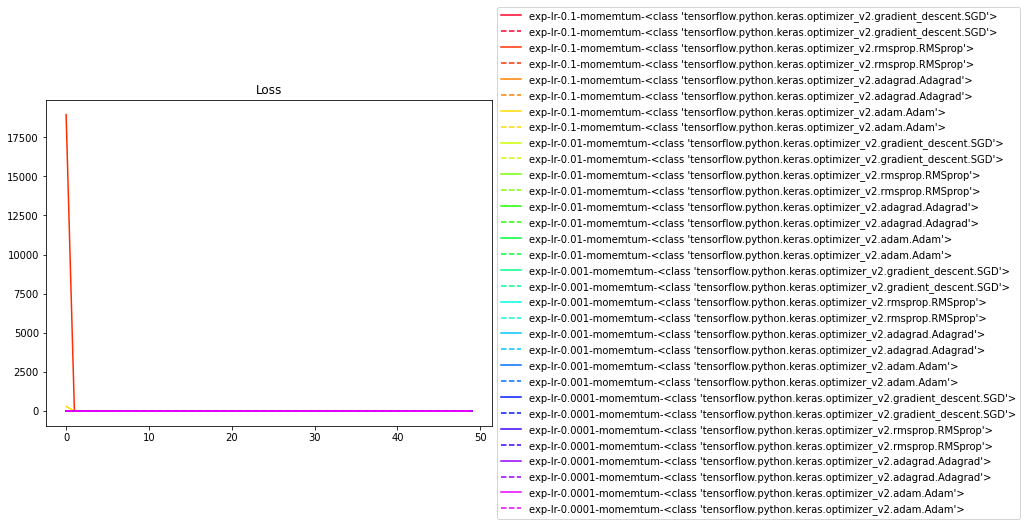

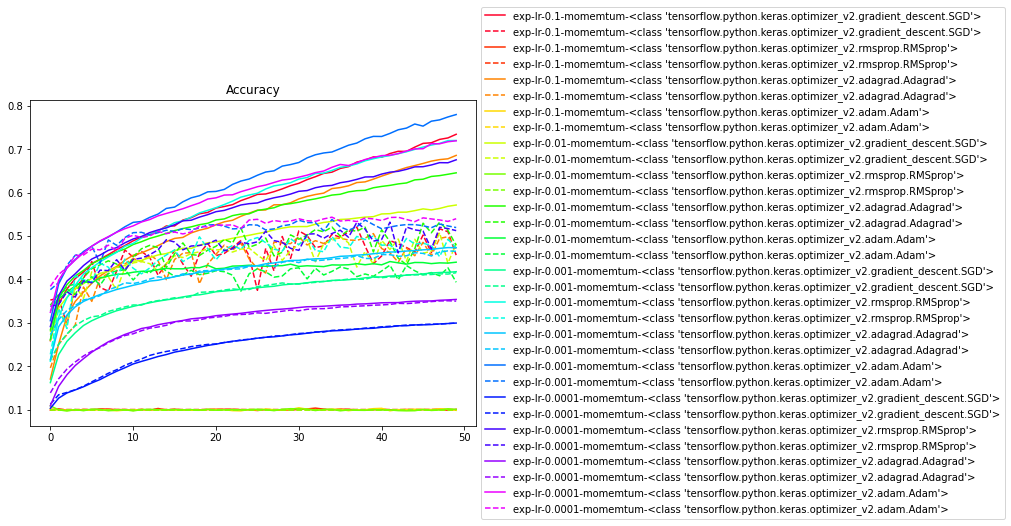

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()